In [1]:
# @title Imports and downloads
import os
import sys
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string
import re
import nltk
import math
import gensim

from PIL import Image
from google.colab import drive

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, sampler
from torch.nn.utils.rnn import pad_sequence
from itertools import chain

nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
from google.colab import drive

In [3]:

drive.mount('/content/gdrive', force_remount=True)
data_path = "/content/gdrive/MyDrive/Medical_Image_Captioning/selected_dataset/selected_dataset" # Joona: Data location in this directory

Mounted at /content/gdrive


In [ ]:
data_path = "/content/gdrive/MyDrive/Colab_Notebooks/Medical_Image_Captioning/selected_dataset/selected_dataset"

### **Task 2:** Visualize sample image/caption pairs from both radiology and non-radiology classes.

In [ ]:
# Path to the downloaded dataset
dataset_path = '/content/gdrive/MyDrive/Colab_Notebooks/Medical_Image_Captioning/selected_dataset/selected_dataset/train'

# Function to load and visualize sample image/caption pairs
def visualize_samples(dataset_path, num_samples=5):
    radiology_folder = os.path.join(dataset_path, 'radiology/images')
    non_radiology_folder = os.path.join(dataset_path, 'non-radiology/images')

    radiology_images = os.listdir(radiology_folder)
    non_radiology_images = os.listdir(non_radiology_folder)

    # Randomly select samples from radiology and non-radiology classes
    radiology_samples = random.sample(radiology_images, num_samples)
    non_radiology_samples = random.sample(non_radiology_images, num_samples)

    # Visualize radiology samples
    print("Radiology Samples:")
    for image_file in radiology_samples:
        image_path = os.path.join(radiology_folder, image_file)
        image = Image.open(image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.show()

    # Visualize non-radiology samples
    print("Non-Radiology Samples:")
    for image_file in non_radiology_samples:
        image_path = os.path.join(non_radiology_folder, image_file)
        image = Image.open(image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.show()

# Visualize 5 samples from each class
visualize_samples(dataset_path, num_samples=5)

In [15]:
# @title Task 7 Clean captions
# Captions preprocessor class

class CaptionsPreprocessor:
  def __init__(self):
      self.stopwords = stopwords
      self.lemmatizer = WordNetLemmatizer()
      self.stemmer = PorterStemmer()
  def remove_stopwords(self, captions):
      return ' '.join([t for t in captions.split() if t not in self.stopwords])
  def remove_punctuations(self, captions):
        captions = re.sub(r'[^\w ]+', "", captions)
        captions = ' '.join(captions.split())
        return captions
  def remove_specials(self, captions):
      return captions.replace('^[A-Za-z]', " ")
  def lemmatize(self, captions):
      return " ".join([self.lemmatizer.lemmatize(word) for word in captions.split()])
  def stem(self, captions):
      return " ".join([self.stemmer.stem(word) for word in captions.split()])
  def remove_extra_spaces(self, captions):
      return captions.replace("\s+"," ")
  def tokenize(self, captions):
      return nltk.word_tokenize(captions)
  def remove_single_char(self, captions):
      return ' '.join([word for word in captions.split() if len(word) > 1])
  def remove_words_with_numbers(self, captions):
      words = captions.split()
      words_without_numbers = [word for word in words if not any(char.isdigit() for char in word)]
      return ' '.join(words_without_numbers)
  def preprocess(self, captions):
      captions = captions.lower()
      captions = self.remove_specials(captions)
      captions = self.remove_punctuations(captions)
      captions = self.remove_extra_spaces(captions)
      captions = self.remove_stopwords(captions)
      captions = self.lemmatize(captions)
      captions = self.stem(captions)
      captions = self.remove_words_with_numbers(captions)
      captions = self.remove_single_char(captions)
      captions = self.tokenize(captions)
      return captions

In [7]:
# @title Task 8 Getting the data
# Captions handling

class ImageCaptionsDataframeHandler:
    # Set paths to datasets
    def __init__(self, path):
        self.train_image_path = os.path.join(path, 'train/radiology/images')
        self.train_captions = os.path.join(path, 'train/radiology/traindata.csv')
        self.val_image_path = os.path.join(path, 'validation/radiology/images')
        self.val_captions = os.path.join(path, 'validation/radiology/valdata.csv')
        self.test_image_path = os.path.join(path, 'test/radiology/images_all')
        self.test_captions = os.path.join(path, 'test/radiology/testdata.csv')

    # Creates an image-caption dataframe from a dataset
    def create_df(self, csv_path, images):
        csv_df = pd.read_csv(csv_path)
        image_captions_df = pd.DataFrame(columns=['image', 'caption'])

        for index, row in csv_df.iterrows():
            image_path = os.path.join(images, row['name'])

            if os.path.exists(image_path) and image_path.endswith('.jpg'):
                image_captions_df = image_captions_df.append({
                    "image": row['name'],
                    "caption": row['caption']
                }, ignore_index=True)

        return image_captions_df

    # Creates training image-caption dataframe
    def get_training_dataframe(self):
        return self.create_df(self.train_captions, self.train_image_path)

    # Creates validation image-caption dataframe
    def get_val_dataframe(self):
        return self.create_df(self.val_captions, self.val_image_path)

    # Creates testing image-caption dataframe
    def get_test_dataframe(self):
        return self.create_df(self.test_captions, self.test_image_path)

class VocabularyHandler:
    def __init__(self):
        self.idxtow = {0: "<START>", 1: "<STOP>", 2: "<UNK>"}
        self.wtoidx = {"<START>": 0, "<STOP>": 1, "<UNK>": 2}
        self.preprocessor = CaptionsPreprocessor()
        self.caption_lengths = []

    def __len__(self):
        return len(self.idxtow)

    def build_vocab(self, captions_list):

        vocab = set()
        idx = 3

        for caption in captions_list:
            self.caption_lengths.append(len(self.preprocessor.preprocess(caption)))
            vocab.update(set(self.preprocessor.preprocess(caption)))

        for word in vocab:
            self.wtoidx[word] = idx
            self.idxtow[idx] = word
            idx = idx + 1

        #print(self.caption_lengths)

    def caption_to_num(self, text):
        print(self.preprocessor.preprocess(text))
        return [
            self.wtoidx[word] if word in self.wtoidx else self.wtoidx["<UNK>"]
            for word in self.preprocessor.preprocess(text)
        ]

In [8]:
# @title Dataset class

def open_image(image_dir, image_name):
    return Image.open(os.path.join(image_dir, image_name)).convert("RGB")

class MedicalImagingDataset(Dataset):
    def __init__(self, image_dir, input_dataframe, batch_size, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.df = input_dataframe
        self.batch_size = batch_size

        self.images = self.df["image"]
        self.captions = self.df["caption"]

        self.vocab = VocabularyHandler()
        self.vocab.build_vocab(self.captions.tolist())

        self.caption_lengths = self.vocab.caption_lengths

    def __len__(self):
       return len(self.df)

    def __getitem__(self, idx):
        caption = self.captions[idx]
        image = open_image(self.image_dir, self.images[idx])

        if self.transform is not None:
            image = self.transform(image)

        caption_as_nums = [self.vocab.wtoidx["<START>"]]
        caption_as_nums += self.vocab.caption_to_num(caption)
        caption_as_nums.append(self.vocab.wtoidx["<STOP>"])

        return image, torch.tensor(caption_as_nums).long()

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

In [9]:
# @title Training dataloader

def data_loader(image_folder, input_df, transform, batch_size, shuffle=False):
    dataset = MedicalImagingDataset(image_dir=image_folder, input_dataframe=input_df, batch_size=batch_size, transform=transform)
    indices = dataset.get_train_indices()
    initial_sampler = sampler.SubsetRandomSampler(indices=indices)

    loader = DataLoader(
        dataset=dataset,
        num_workers=1,
        batch_sampler=sampler.BatchSampler(sampler=initial_sampler, batch_size=batch_size, drop_last=False),
        shuffle=shuffle
    )
    return loader, dataset

### Encoder

In [10]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.batch= nn.BatchNorm1d(embed_size,momentum = 0.01)
        self.embed.weight.data.normal_(0., 0.02)
        self.embed.bias.data.fill_(0)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.batch(self.embed(features))
        return features

### Decoder (Work in Progress)

In [11]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embed_size= embed_size
        self.drop_prob= 0.2
        self.vocabulary_size = vocab_size
        self.lstm = nn.LSTM(self.embed_size, self.hidden_size , self.num_layers,batch_first=True)
        self.dropout = nn.Dropout(self.drop_prob)
        self.embed = nn.Embedding(self.vocabulary_size, self.embed_size)
        self.linear = nn.Linear(hidden_size, self.vocabulary_size)
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.linear.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, features, captions):
        embeddings = self.embed(captions)
        features = features.unsqueeze(1)
        embeddings = torch.cat((features, embeddings[:, :-1,:]), dim=1)
        hiddens, c = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

    def sample(self, features, vocab, max_length=50):
        result_caption = []
        x = features.unsqueeze(0)

        with torch.no_grad():
            states = None

            for _ in range(max_length):
                hidden_s, states = self.lstm(x, states)
                out = self.linear(hidden_s.squeeze(0))
                predicted = out.argmax(1)

                if vocab.idxtow[predicted.item()] == "<STOP>":
                    break

                result_caption.append(predicted.item())
                x = self.embed(predicted).unsqueeze(0)

        return [vocab.idxtow[idx] for idx in result_caption]

    def init_hidden_state(self, features):

        mean_features = features.mean(dim=1)
        h = torch.zeros((self.num_layers, 1, self.hidden_size), device=self.device)
        c = torch.zeros((self.num_layers, 1, self.hidden_size), device=self.device)
        return h, c

In [12]:
# Create dataframes with image names and captions from the training dataset for now

dfc = ImageCaptionsDataframeHandler(path=data_path)

train_dataframe = dfc.get_training_dataframe()
val_dataframe = dfc.get_val_dataframe()
test_dataframe = dfc.get_test_dataframe()

Striimattava tuloste lyhennetty viimeiseen 5000 riviin.
<ipython-input-7-09c123c174ac>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_captions_df = image_captions_df.append({
<ipython-input-7-09c123c174ac>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_captions_df = image_captions_df.append({
<ipython-input-7-09c123c174ac>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_captions_df = image_captions_df.append({
<ipython-input-7-09c123c174ac>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_captions_df = image_captions_df.append({
<ipython-input-7-09c123c174ac>:23: FutureWarning: The frame.append method is

In [16]:
# @title Parameters etc.

transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]
)

# Saving location
model_path = "/content/gdrive/MyDrive/Medical_Image_Captioning/model/JKO"

# Hyperparameters
embed_size = 512 # Size of the image embeddings
hidden_size = 512  # Size of the hidden states in the LSTM decoder
batch_size = 20
num_layers = 1
learning_rate = 1e-3
num_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training loader and dataset
train_loader, train_dataset = data_loader(dfc.train_image_path, train_dataframe, transform, batch_size)

# Validation loader and dataset
val_loader, val_dataset = data_loader(dfc.val_image_path, val_dataframe, transform, batch_size)

# Test loader and dataset
test_loader, test_dataset = data_loader(dfc.test_image_path, test_dataframe, transform, 1)

vocab_size = len(train_dataset.vocab)

encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.embed.parameters())

optimizer = optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)


#for name, param in encoder.densenet.named_parameters():
#        if "fc.weight" in name or "fc.bias" in name:
#            param.requires_grad = True
#        else:
#            param.requires_grad = False

total_step = math.ceil(len(train_dataset.caption_lengths) / train_loader.batch_sampler.batch_size)

# get the losses for vizualization
losses = list()
val_losses = list()
save_every = 1

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 114MB/s]


In [ ]:
print(vocab_size)

5260


In [17]:
# @title Training loop

def training():

    # Training loop
    for epoch in range(1, num_epochs+1):

        for i_step in range(1, total_step+1):

            # zero the gradients
            decoder.zero_grad()
            encoder.zero_grad()

            # set decoder and encoder into train mode
            encoder.train()
            decoder.train()

            # Randomly sample a caption length, and sample indices with that length.
            indices = train_dataset.get_train_indices()

            # Create and assign a batch sampler to retrieve a batch with the sampled indices.
            new_sampler = sampler.SubsetRandomSampler(indices=indices)
            train_loader.batch_sampler.sampler = new_sampler
            #val_loader.batch_sampler.sampler = new_sampler

            # Obtain the batch.
            images, captions = next(iter(train_loader))

            # make the captions for targets and teacher forcer
            captions_target = captions[:, 1:].to(device)
            captions_train = captions[:, :captions.shape[1]-1].to(device)

            # Move batch of images and captions to GPU if CUDA is available.
            images = images.to(device)

            # Pass the inputs through the CNN-RNN model.
            features = encoder(images)
            outputs = decoder(features, captions_train)

            # Calculate the batch loss
            loss = criterion(outputs.view(-1, vocab_size), captions_target.contiguous().view(-1))

            # Backward pass
            loss.backward()

            # Update the parameters in the optimizer
            optimizer.step()

            # - - - Validate - - -
            # turn the evaluation mode on
            with torch.no_grad():

                # set the evaluation mode
                encoder.eval()
                decoder.eval()

                # get the validation images and captions
                val_images, val_captions = next(iter(val_loader))

                # define the captions
                captions_target = val_captions[:, 1:].to(device)
                captions_train = val_captions[:, :val_captions.shape[1]-1].to(device)

                # Move batch of images and captions to GPU if CUDA is available.
                val_images = val_images.to(device)

                # Pass the inputs through the CNN-RNN model.
                features = encoder(val_images)
                outputs = decoder(features, captions_train)

                # Calculate the batch loss.
                val_loss = criterion(outputs.view(-1, vocab_size), captions_target.contiguous().view(-1))

            # append the validation loss and training loss
            val_losses.append(val_loss.item())
            losses.append(loss.item())

            # save the losses
            np.save('losses', np.array(losses))
            np.save('val_losses', np.array(val_losses))

            # Get training statistics.
            stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Val Loss: %.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), val_loss.item())

            # Print training statistics (on same line).
            print('\r' + stats, end="")
            sys.stdout.flush()

        # Save the weights.
        if epoch % save_every == 0:
            print("\nSaving the model")
            torch.save(decoder.state_dict(), os.path.join(model_path, 'decoder-%d.pth' % epoch))
            torch.save(encoder.state_dict(), os.path.join(model_path, 'encoder-%d.pth' % epoch))

In [ ]:
training()

Epoch [1/10], Step [125/125], Loss: 5.7282, Val Loss: 9.0896
Saving the model
Epoch [2/10], Step [125/125], Loss: 5.9068, Val Loss: 9.0753
Saving the model
Epoch [3/10], Step [125/125], Loss: 4.9884, Val Loss: 9.7146
Saving the model
Epoch [4/10], Step [125/125], Loss: 5.0213, Val Loss: 9.9165
Saving the model
Epoch [5/10], Step [125/125], Loss: 5.4466, Val Loss: 9.9074
Saving the model
Epoch [6/10], Step [125/125], Loss: 5.7146, Val Loss: 9.9712
Saving the model
Epoch [7/10], Step [125/125], Loss: 5.2796, Val Loss: 10.4551
Saving the model
Epoch [8/10], Step [125/125], Loss: 6.0750, Val Loss: 10.7769
Saving the model
Epoch [9/10], Step [125/125], Loss: 2.9107, Val Loss: 10.7045
Saving the model
Epoch [10/10], Step [125/125], Loss: 3.7298, Val Loss: 11.2447
Saving the model


In [18]:
# @title Testing the model

# TODO #2: Specify the saved models to load.
encoder_file = os.path.join(model_path, 'encoder-10.pth')
decoder_file = os.path.join(model_path, 'decoder-10.pth')

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 512
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(train_loader.dataset.vocab)
print(vocab_size)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(encoder_file, map_location=torch.device('cpu')))
decoder.load_state_dict(torch.load(decoder_file, map_location=torch.device('cpu')))

#encoder.load_state_dict(torch.load(encoder_file))
#decoder.load_state_dict(torch.load(decoder_file))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

5260


DecoderRNN(
  (lstm): LSTM(512, 512, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (embed): Embedding(5260, 512)
  (linear): Linear(in_features=512, out_features=5260, bias=True)
)

In [ ]:
print(len(train_loader.dataset.vocab.wtoidx))

3713


In [19]:
def get_predictions():
    # Randomly sample a caption length, and sample indices with that length.
    indices = test_dataset.get_train_indices()

    # Create and assign a batch sampler to retrieve a batch with the sampled indices.
    new_sampler = sampler.SubsetRandomSampler(indices=indices)
    test_loader.batch_sampler.sampler = new_sampler

    image, captions = next(iter(test_loader))
    plt.imshow(np.squeeze(image).T)
    plt.title('Sample Image')
    plt.show()

    image = image.to(device)

    features = encoder(image)
    #output = decoder.generate_caption(features, train_loader.dataset.vocab)
    output = decoder.sample(features, train_loader.dataset.vocab)

    print(output)

['mri', 'scan', 'axial', 'view', 'suggest', 'sphenoid', 'wing', 'dysplasia', 'right', 'herniat', 'right', 'frontotempor', 'lobe', 'tempor', 'horn', 'right', 'ventricl', 'csf', 'defect', 'hemiatrophi', 'right', 'cerebr', 'hemispher']


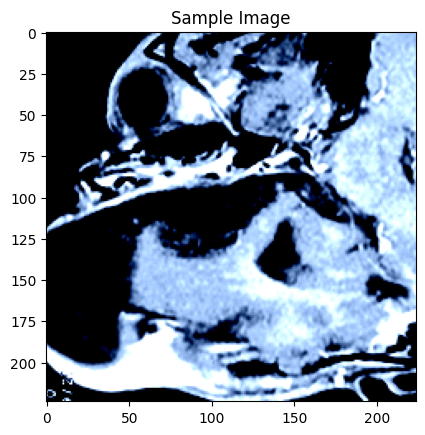

['civ', 'ellipsoid', 'perfect', 'bold', 'pain', 'captur']


In [26]:
get_predictions()

In [ ]:
# @title Task 8 Create vocabulary and word to index dictionary

preprocessor = CaptionsPreprocessor()

captions_list = list(train_dataframe["caption"])

# Preprocess etc.

In [ ]:
cleaned_captions = []

for x in range(len(captions_list)):
    cleaned_captions.append(preprocessor.preprocess(captions_list[x]))

In [ ]:
# @title Vectorize vocabulary


# Continuing from here. Create word2vec and/or GloVe vectors. Should we train our own word vectors on the vocabulary or use the pretrained models?